# U. S. Scholastic Aptitude Test
---

In the following project we would like to find out whether the SAT, or Scholastic Aptitude Test is unfair to certain groups. The SAT is am exam that U.S. high school students take before applying to college. We will investigate correlations between SAT scores and demographics with factors like race, gender, district, and more. 
 
The exam consists of three sections, each of which has 800 possible points. We based our project on 2,400 total points. The data regarding SAT scores for each high school in New York City is available online, on [NYC Open Data website](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4).

We decided to supplement our data with other, following sources to do our full analysis:
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school
All of these data sets are interrelated.

New York City schools fall within several different school districts, each of which can contains dozens of schools.
Our data sets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
Each school in New York City has a unique code called a DBN, or district borough number.
Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.

## Reading the data sets

In the first part of the project we will read each file into dataframe and then store all of the dataframes in a dictionary. Doing so will enable a quick refrence to the data set and give us a convenient way to store the data.

In [1]:
# Importing relevant libraries
import pandas as pd
import numpy
import re

# Listing the csv files
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Storing the dataframes in a dictionary
data = {}

for f in data_files:
    d = pd.read_csv("schools_nyc/{0}".format(f))
    data[f.replace(".csv", "")] = d

We are mainly interested in the SAT data set, which corresponds to the dictionary key sat_results. This data set contains the SAT scores for each high school in New York City. We eventually want to correlate selected information from this data set with information in the other data sets.

We will explore sat_results to see what we can discover. Exploring the dataframe will help us understand the structure of the data, and make it easier for us to analyze it.

In [2]:
# Exploring sat_results data set
print(data['sat_results'].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

In [3]:
# Exploring sat_results data set
print(data['sat_results']['SCHOOL NAME'].value_counts())

GEORGE WESTINGHOUSE CAREER AND TECHNICAL EDUCATION HIGH SCHOOL           1
WEST BROOKLYN COMMUNITY HIGH SCHOOL                                      1
THE CINEMA SCHOOL                                                        1
ACADEMY OF INNOVATIVE TECHNOLOGY                                         1
URBAN ASSEMBLY SCHOOL OF DESIGN AND CONSTRUCTION, THE                    1
QUEENS PREPARATORY ACADEMY                                               1
URBAN ASSEMBLY ACADEMY FOR HISTORY AND CITIZENSHIP FOR YOUNG MEN, THE    1
METROPOLITAN CORPORATE ACADEMY HIGH SCHOOL                               1
URBAN ACTION ACADEMY                                                     1
BRONX HIGH SCHOOL OF BUSINESS                                            1
MIDDLE COLLEGE HIGH SCHOOL AT LAGUARDIA COMMUNITY COLLEGE                1
SOUTH RICHMOND HIGH SCHOOL I.S./P.S. 25                                  1
P.S. 035                                                                 1
INTERNATIONAL ARTS BUSINE

Based on the output we can make the following observations:
- the DBN seems to be a unique ID for each school,
- the data regards high schools only, 
- there is only a single row for each high school, so each DBN is unique in the SAT data.

The three columns that contain SAT scores: SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score could be easier to analyze while combined into single column.

The next step will be to explore the other data sets.

In [4]:
# Exploring other data sets
for key in data:
    print("Data Set:", key)
    print(data[key].head())

Data Set: ap_2010
      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
Data Set: class_size
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto

In class_size data set the DBN is splitted into three columns: CSD, BOROUGH and SCHOOL CODE. Apart from that each data set appears to have a DBN column. That means we can use a DBN column to combine the data sets.

First we'll look for identical DBNs, then group all of columns together in a single data set. We need to pay attention to the fact that some rows contain duplicate DBN values. We will need to process the data so that each DBN is unique. 

## Reading survey data

Before we move to merging the data sets, we will read the remaining data sets, which we didn't read earlier because their format is different and slightly more complex.

In [5]:
# Reading survey data sets
all_survey = pd.read_csv("schools_nyc/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools_nyc/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Combining the data sets
survey = pd.concat([all_survey, d75_survey], axis=0)
# Exploring the data set
print(survey.head())

     N_p    N_s   N_t  aca_p_11  aca_s_11  aca_t_11  aca_tot_11    bn  \
0   90.0    NaN  22.0       7.8       NaN       7.9         7.9  M015   
1  161.0    NaN  34.0       7.8       NaN       9.1         8.4  M019   
2  367.0    NaN  42.0       8.6       NaN       7.5         8.0  M020   
3  151.0  145.0  29.0       8.5       7.4       7.8         7.9  M034   
4   90.0    NaN  23.0       7.9       NaN       8.1         8.0  M063   

   com_p_11  com_s_11  ...  t_q8c_1  t_q8c_2  t_q8c_3 t_q8c_4  t_q9  t_q9_1  \
0       7.6       NaN  ...     29.0     67.0      5.0     0.0   NaN     5.0   
1       7.6       NaN  ...     74.0     21.0      6.0     0.0   NaN     3.0   
2       8.3       NaN  ...     33.0     35.0     20.0    13.0   NaN     3.0   
3       8.2       5.9  ...     21.0     45.0     28.0     7.0   NaN     0.0   
4       7.9       NaN  ...     59.0     36.0      5.0     0.0   NaN    10.0   

   t_q9_2  t_q9_3  t_q9_4  t_q9_5  
0    14.0    52.0    24.0     5.0  
1     6.0     

C:\Users\malgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Our merged survey data set contains 2773 columns. This is a huge amount, which is unnecessary and will not support our analysis. We will choose only most useful columns based on provided [survey data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8). These columns will give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It will also provide information regarding the DBN, which allows us to uniquely identify the school. Furthermore, we will rename dbn column to uppercase (DBN) in order to make it consistent with the other data sets.

We need to understand what is hiding under the column names, that we going to work on:
- "DBN" - school identification code (district borough number),
- "rr_s", "rr_t", "rr_p" - response rate of student, teacher, parent,
- "N_s", "N_t", "N_p", Number of respondents (students, teachers, parents)
- "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11" - safety, communication, engagement, academic expectations scores on parent responses, 
- "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11" - safety, communication, engagement, academic expectations scores on parent responses, 
- "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11" - safety, communication, engagement, academic expectations scores on parent responses, 
- "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11" - safety, communication, engagement, academic expectations total scores.

In [6]:
# Renaming the dbn column to uppercase
survey["DBN"] = survey["dbn"]

# Filtering the columns
survey_fields = [
    "DBN",
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## DBN column

As we mentioned earlier on, each data set has a DBN data, however, hs_directory has it saved as dbn and class_size has it splitted into three columns. We will rename the dbn column in hs_directory and combine the columns in class_size so that DBN column was presented in the same way across data sets.

The DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long.

In [7]:
print(data['class_size'].iloc[:, 0:3].head())

   CSD BOROUGH SCHOOL CODE
0    1       M        M015
1    1       M        M015
2    1       M        M015
3    1       M        M015
4    1       M        M015


In [8]:
# Renaming dbn column to uppercase
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Writing a function for zero padded number
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
# Applying the function   
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
# Assigning the result of addition to DBN coulumn
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Combining SAT scores

As mentioned, the three columns that contain SAT scores: SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score could be easier to analyze while combined into single column. In order to add the columns together, we will convert sat_results data set from string data type to numeric one. 

In [9]:
# Listing the columns
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
# Converting the columns to numeric data type
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# Summing the columns
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
# Exploring the new column
print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


To map the schools and uncover any geographic patterns in the data, we will parse the latitude and longitude coordinates for each school. We can find the coordinates in the text field of Location 1 column in the hs_directory data set.

In [10]:
# Exploring the Location 1 column
print(data['hs_directory']['Location 1'].head())

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object


Our goal is to extract the latitudes and the longitudes. Taken together, latitude and longitude make up a pair of coordinates that allows us to pinpoint any location on Earth.

In [11]:
# Writing a function to extract latitudes
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Writing a function to extract longitudes
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Applying functions to extract latitudes and longitudes
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Converting latitudes and longitudes columns to numeric data types
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condensing datasets

Before we merge the data sets, we will have to condense some of them. As we noticed in previous steps, the values in the DBN column were unique in the sat_results data set, however other data sets contained duplicate DBN values. We aim to end up with one DBN value, otherwise we might run into issues while combining the data sets. 

We will start the condensing process with class_size data set.

In [12]:
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


As stated above, the first few rows all pertain to the same school, which is why the DBN appears more than once. It seems to be that each school has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT (MS CORE and 9-12 ONLY), and CORE COURSE (MS CORE and 9-12 ONLY). We are interested in high schools, so the appropriate grade would be from 9 to 12. Regarding PROGRAM TYPE column, we will choose only one, which is GEN ED because it is the largest category.

In [13]:
# Creating a new variable
class_size = data["class_size"]
# Filtering the GRADE column
class_size = class_size[class_size["GRADE "] == "09-12"]
# Filtering the PROGRAM TYPE column
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#Finding average values for each column associated with each DBN in class_size
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Selecting only 2011/2012 school year
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Selecting only data from the most recent Cohort
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Converting AP scores to numeric

We would like to convert columns regarding AP (Advanced Placement) test, which high school student take before applying to college. The exam is passed from 3 or higher score (1 to 5 scale). It could be interesting to check if there is a correlation between SAT scores and AP scores.

In [14]:
# Relevant columns
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

# Converting the columns to numeric data type
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combining the datasets

In this project we are interested in determining demographic factors correlating with SAT score. Therefore, we would like to preserve as many sat_results rows as possible.

In [15]:
# Assigning sat_results column to variable combined
combined = data["sat_results"]

# Merging data sets
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# Filling the missing data    
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Adding a school district column for mapping

We are interested in mapping statistics out on a school district level. We will add a column to the data set, which will specify the school district.

In [16]:
# Writing a function for extracting school district number
def get_first_two_chars(dbn):
    return dbn[0:2]

# Applying the function
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Finding correlations

Our data set is now ready to find out correlations. As we would like to understand if there is the fairness of the SAT, a strong positive or negative correlation between a demographic factor like gender or race and SAT score would bring usuful insights into our anaysis. 

In [17]:
# Checking for all possible correlations
correlations = combined.corr()
# Filtering for sat_score column's correlations
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

We can observe that, unsurprisingly, sat_score is strongly correlated with  columns: SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score.

We can also notice that there is a strong positive correlation in case of total_enrollment and sat_score columns, which means that larger schools tend to have better scores on the SAT. Columns: total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, NUMBER OF SECTIONS are characterized with a similar correlation. 

Furthermore, there is a significant racial difference in SAT scores (white_per, asian_per, black_per, hispanic_per). We can also notice that the percentage of English language learners correlates negatively with SAT scores (columns ell_percent, frl_percent).

## Plotting survey correlations

Now it is time to extend our analysis and create some data visualization. We will start by plotting the correlations in a bar plot.

In [18]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

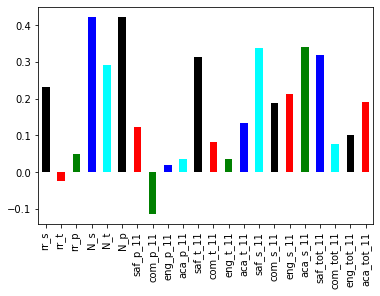

In [19]:
# Setting matplotlib and plotting a bar plot
%matplotlib inline
correlations[survey_fields].plot.bar(color = ['black', 'red', 'green', 'blue', 'cyan'])

We are now about to interpret the finding regarding correlation between sat_score and survey_fields columns. As we can see on the bar plot, the highest positive correlation can be observed in case of number of student (N_s) and parent (N_p) respondents - more than 0.4. Slightly less, about 0.3 rate, we can find number of teacher (N_t) respondents, safety (saf_t_11, saf_s_11, saf_tot_11), academic expectations (aca_s_11). Other fields or survey were quite weakly correlated with SAT score.

## Exploring Safety and SAT Scores

What could be an interesting finding, is that in some part, the general safety at school for both teachers and students leads to better results on the SAT. We would like to understand the relation between safety and SAT score better. We will investigate schools with low safety levels and find out what the score results are.

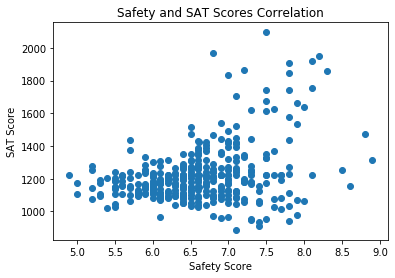

In [29]:
# Importing library
import matplotlib.pyplot as plt
# Plotting a scatter plot
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.title("Safety and SAT Scores Correlation")
plt.xlabel("Safety Score")
plt.ylabel("SAT Score")
plt.show()

The correlation between Sat Score and Safety does not seem to be that strong. There are some outlires with high SAT and safety scores, however there are some with high safety and low SAT scores. We can also notice, that in case of schools with Safety Score lower than 6.5 there is no SAT Score higher than 1500. 

C:\Users\malgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\malgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


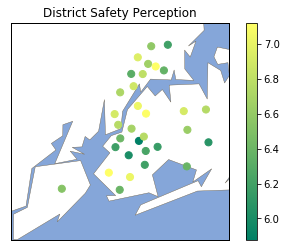

In [30]:
# Setting os environment
import os
os.environ["PROJ_LIB"] = "C:\\Users\\malgo\\Anaconda3\\Lib\\site-packages\\mpl_toolkits\\basemap"
# Importing basemap
from mpl_toolkits.basemap import Basemap

# Computing an average safety score for each district
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

# Plotting a map which shows safety scores by district
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.title("District Safety Perception")
plt.colorbar()
plt.show()

We can observe, that in general Upper Manhattan and some parts of Queens have quite high safety rates. The lower rates can be found mainly in Brooklyn.

## Exploring Race and SAT Scores

The data indicates four following percentage groups: white_per, asian_per, black_per, hispanic_per. In this step we will plot correlations between those groups and sat_score to understand if there are some racial differences in SAT performance.

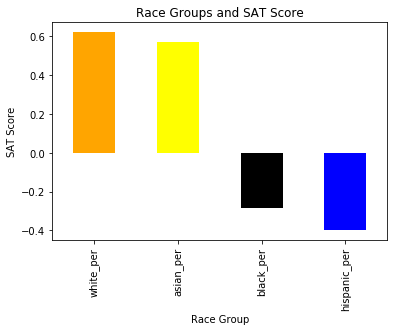

In [53]:
# Plotting a bar plot regarding correlations for various racial groups
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot.bar(color = ['orange', 'yellow', 'black', 'blue'])
plt.xlabel("Race Group")
plt.ylabel('SAT Score')
plt.title("Race Groups and SAT Score")
plt.show()

Looking at above bar plot, we can notice that there is quite strong positive  correlation of SAT score for white and asian groups. The negative correlation can be observed in case of black and hispanic groups. The findings indicate that white and asian groups do better on SAT test.

The highest negative correlation has been found in hispanic group so we would like to investigate schools with the highest hispanic percentage groups.

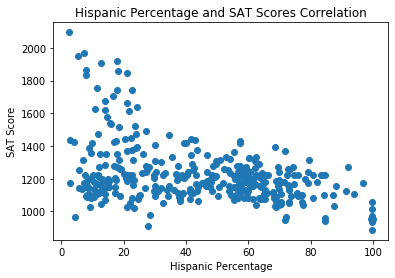

In [52]:
# Plotting scatter plot
plt.scatter(combined['hispanic_per'], combined['sat_score'])
plt.title("Hispanic Percentage and SAT Scores Correlation")
plt.xlabel("Hispanic Percentage")
plt.ylabel("SAT Score")
plt.show()

The correlation for SAT score and Hispanic Percentage is weak, however, we can notice that schools with more than 30% Hispanic Percentage are not likely to score more than 1600 SAT Score.

In [51]:
# Finding schools with high hispanic percentage
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

There are eight high schools in NYC where Hispanic Percentage is higher than 95%. These schools do not have high SAT scores.

In [50]:
# Finding schools with low hispanic percentage and high SAT score
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

There are five high schools with very high SAT score. The percentage of Hispanic is low there (below 10%).

## Exploring Gender and SAT Scores

The data allows analysis regarding gender at schools. We will check if there are any correlations with SAT score.

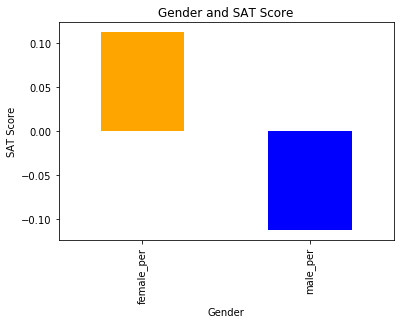

In [60]:
# Plotting a bar plot regarding correlations for gender and SAT score
correlations[['female_per', 'male_per']].plot.bar(color = ['orange', 'blue'])
plt.xlabel("Gender")
plt.ylabel('SAT Score')
plt.title("Gender and SAT Score")
plt.show()

We can observe little positive correlation in case of female_per and slight negative one in case of male_per and SAT score. The result indicates that in schools with higher female percentage the SAT score is more likely to be high.

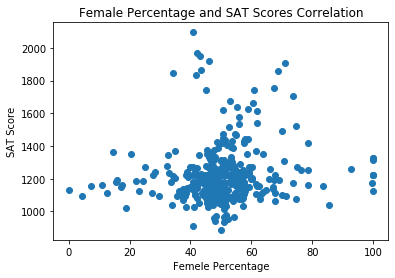

In [62]:
# Plotting a scatter plot
plt.scatter(combined['female_per'], combined['sat_score'])
plt.title("Female Percentage and SAT Scores Correlation")
plt.xlabel("Femele Percentage")
plt.ylabel("SAT Score")
plt.show()

There is no clear correlation between female percentage and SAT score. Anyway there is some cluster of schools with high female percentage and SAT score.

In [64]:
# Finding schools with high female percentage and high SAT score
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

There are five high schools with female percentage higher than 60% and SAT score higher than 1700. The schools seem to be of high academic standards and being very selective liberal arts schools. It could be interesting how the number looks like in case of males.

In [65]:
# Finding schools with high male percentage and high SAT score
combined[(combined['male_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

79    HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
Name: SCHOOL NAME, dtype: object

There is one high school with male percentage higher than 60% and SAT score higher than 1700. The school is in STEM field.

## Advanced Placement Exam and SAT Score

Advanced Placement (AP) exams are taken by high school students in U.S. to earn college credit. The AP exam can be taken on very many different subjects. We anticipate, that schools with high number of students who take AP exams would be highly correlated with the school's SAT scores. 

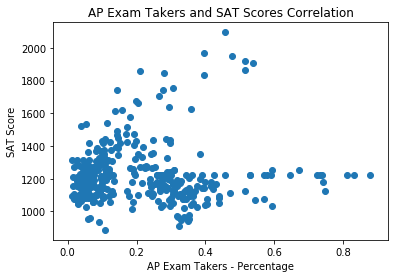

In [73]:
# Calculating the percentage of students in each school that took an AP exam
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

# Plotting a scatter plot
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.title("AP Exam Takers and SAT Scores Correlation")
plt.xlabel("AP Exam Takers - Percentage")
plt.ylabel("SAT Score")
plt.show()

There is almost no correlation between AP exam takers and SAT scores. There are even some outlires where the percentage of students who took AP exam is higher than 60%, however SAT score is below 1400.

## Class size vs. SAT score

We can anticipate that the smaller the class is, the more attention the students get and therefore the better SAT score is. We will try to find out whether our assumption is correct.

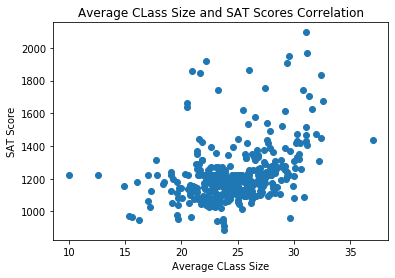

In [76]:
# Plotting a scatter plot
plt.scatter(combined['AVERAGE CLASS SIZE'], combined['sat_score'])
plt.title("Average CLass Size and SAT Scores Correlation")
plt.xlabel("Average CLass Size")
plt.ylabel("SAT Score")
plt.show()

It looks like there is no correlation between class size and SAT score. Classes with size less than 20 do not have SAT score higher than 1400.

## Neighborhoods with the Best Schools

C:\Users\malgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\malgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


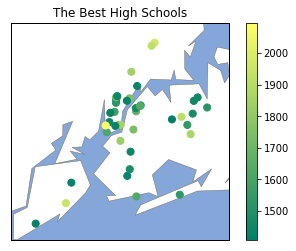

In [79]:
# Filtering for schools with the highest SAT score
best_schools = combined[combined['sat_score'] > 1400]

# Plotting a map which shows the best schools by district
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = best_schools["lon"].tolist()
latitudes = best_schools["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=best_schools["sat_score"], cmap="summer")
plt.title("The Best High Schools")
plt.colorbar()
plt.show()

The best high schools can be found in any district of NYC. The highest number of high schools with SAT score higher than 1400 can be noticed in Manhattan and Queens.

## Parent, Teacher and Student Survey Resposes

We have already some insights into the relationship between SAT score and various factors like race, gender, district neighbourhood. Before we come to conclusions, we would like to investigate whether there are some diffferences between teacher, parent and student responses to surveys.

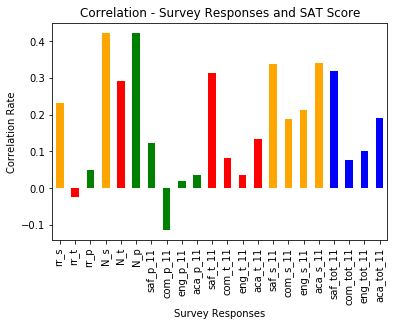

In [88]:
# Plotting survey correlations with SAT score
correlations[survey_fields].plot.bar(color = ['orange', 'red', 'green', 'orange', 'red', 'green', 'green', 'green', 'green','green', 'red', 'red', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'blue', 'blue', 'blue', 'blue' ])
plt.title("Correlation - Survey Responses and SAT Score")
plt.xlabel("Survey Responses")
plt.ylabel("Correlation Rate")
plt.show()

The above bar plot represents correlation of SAT score and various survey responses. The orange color indicates student responses, red - teachers, green - parents, blue - total. 

We can notice that the higher the response rate, slightly higher the SAT score but only in case of students (rr_s). Parents and teacher responses to the survey seem to have no correlation with the SAT score (rr_t, rr_p). The number of students and parents (N_s, N_p) shows the highest positive correlation (more than 0.4). In case of number of teacher respondents the correlation was lower (0.3). 

Looking at safety, there seems to be some positive relationship between the SAT score results and school safety but only in case of students and teachers (saf_t_11), (saf_s_11). 

There seems to be also a difference in case of communication. Interestingly in case of parents (com_p_11) it is even negative. 

All four factors - safety, communication, engagement, academic expectations, have higher correlation in case of students. The parents and teachers results seem to have lesser impact on the SAT score.

# Conclusions
---

In the project we investigated correlations between SAT scores and demographics with factors like race, gender, district, and more. Our main findings are:
- larger schools tend to have better scores on the SAT,
- there is a significant racial difference in SAT scores,
- the percentage of English language learners correlates negatively with SAT scores,
- higher safety plays a role in the better SAT results, however there is no strong correlation,
- negative correlation of SAT score has been found for Hispanic and Black groups,
- schools with higher female percentage tend to do better on the SAT,
- there is almost no correlation between AP exam takers and SAT scores,
- smaller classes (with 20 and less students) do not have higher SAT scores,
- the best high schools can be found in any NYC district, however the greatest number of them should be in Manhattan and Queens.

In order to increase SAT fairness and the SAT results at high schools, it could be a good idea to increase support for students who are English learners. High schools could organize extra English classes for these students and also put more emphasis on the SAT exam preparation. 